In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [4]:
#@title Plotting Settings

def plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(4, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title("Synaptic Conductance-based Neuron Model With Input Spikes")
  ax[0].set_yticks([]) 

  # Plot membrane potential
  ax[1].plot(syn_rec.detach().numpy())
  ax[1].set_ylim([0, 0.5])
  ax[1].set_ylabel("Synaptic Current ($I_{syn}$)")
  plt.xlabel("Time step")

  # Plot membrane potential
  ax[2].plot(mem_rec.detach().numpy())
  ax[2].set_ylim([0, 1.5])
  ax[2].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[2].axhline(y=1, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[3], s=400, c="black", marker="|")
  plt.ylabel("Output spikes")
  ax[3].set_yticks([]) 

  plt.show()

def plot_spk_mem_spk(spk_in, mem_rec, spk_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})

  # Plot input current
  splt.raster(spk_in, ax[0], s=400, c="black", marker="|")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)
  ax[0].set_yticks([]) 

  # Plot membrane potential
  ax[1].plot(mem_rec.detach())
  ax[1].set_ylim([0, 0.6])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  ax[1].axhline(y=0.5, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk_rec, ax[2], s=400, c="black", marker="|")
  ax[2].set_yticks([])
  ax[2].set_ylabel("Output Spikes")

  plt.show()

The synaptic condutance-based neuron model combines the synaptic current dynamics with the passive membrane. It must be instantiated with two input arguments:

alpha: the decay rate of the synaptic current

beta: the decay rate of the membrane potential (as with Lapicque)


In [2]:
alpha = 0.9
beta = 0.8
num_steps = 200

lif1 = snn.Synaptic(alpha=alpha, beta=beta)

![synaptic](synaptic.png)

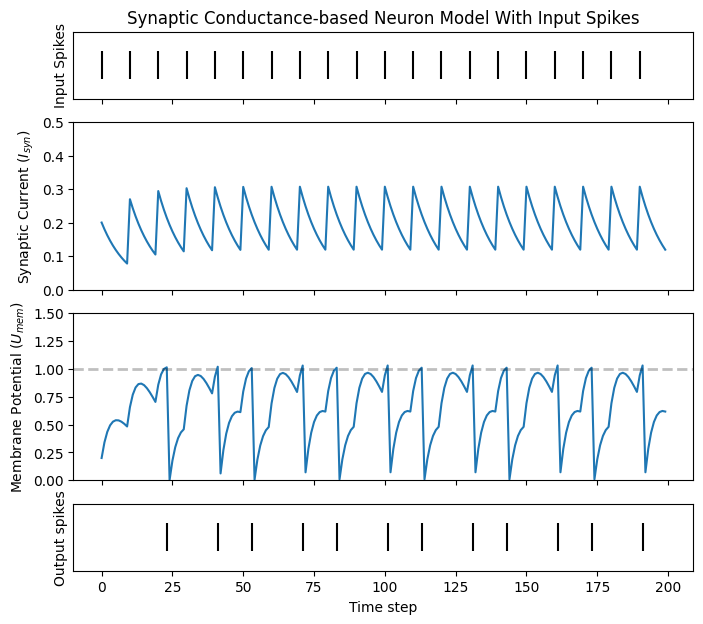

In [5]:
# Periodic spiking input, spk_in = 0.2 V
w = 0.2
spk_period = torch.cat((torch.ones(1)*w, torch.zeros(9)), 0)
spk_in = spk_period.repeat(20)

# Initialize hidden states and output
syn, mem = lif1.init_synaptic()
spk_out = torch.zeros(1)
syn_rec = []
mem_rec = []
spk_rec = []

# Simulate neurons
for step in range(num_steps):
  spk_out, syn, mem = lif1(spk_in[step], syn, mem)
  spk_rec.append(spk_out)
  syn_rec.append(syn)
  mem_rec.append(mem)

# convert lists to tensors
spk_rec = torch.stack(spk_rec)
syn_rec = torch.stack(syn_rec)
mem_rec = torch.stack(mem_rec)

plot_spk_cur_mem_spk(spk_in, syn_rec, mem_rec, spk_rec,
                     "Synaptic Conductance-based Neuron Model With Input Spikes")

In [6]:
alpha = 0.8
beta = 0.7

# initialize neuron
lif2 = snn.Alpha(alpha=alpha, beta=beta, threshold=0.5)

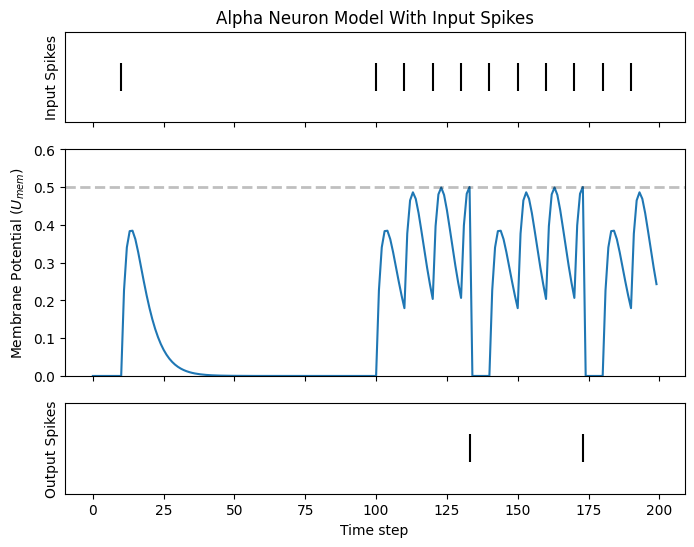

In [7]:
# input spike: initial spike, and then period spiking
w = 0.85
spk_in = (torch.cat((torch.zeros(10), torch.ones(1), torch.zeros(89),
                     (torch.cat((torch.ones(1), torch.zeros(9)),0).repeat(10))), 0) * w).unsqueeze(1)

# initialize parameters
syn_exc, syn_inh, mem = lif2.init_alpha()
mem_rec = []
spk_rec = []

# run simulation
for step in range(num_steps):
  spk_out, syn_exc, syn_inh, mem = lif2(spk_in[step], syn_exc, syn_inh, mem)
  mem_rec.append(mem.squeeze(0))
  spk_rec.append(spk_out.squeeze(0))

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_rec, "Alpha Neuron Model With Input Spikes")